In [1]:
import os
from typing import List, Dict, Any, Optional, TypedDict
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, END


In [2]:
# -----------------------------
# 1) Estado del agente (memoria)
# -----------------------------
class AgentState(TypedDict):
    movie_title: str
    user_tips: List[str]  # criterios del usuario (ej: "odio jumpscares", "me gusta drama lento")
    queries: List[str]
    search_results: List[Dict[str, Any]]   # resultados crudos de búsqueda
    evidence: List[Dict[str, str]]         # evidencias seleccionadas: {source, snippet, url}
    signals: Dict[str, Any]                # señales extraídas (tono, consenso, puntos fuertes/débiles)
    score: Optional[float]                 # 0..10
    verdict: Optional[str]                 # "Recomendada", "Tal vez", "No recomendada"
    reasoning_summary: Optional[str]        # explicación breve (NO chain-of-thought)
    iterations: int




In [3]:
# -----------------------------
# 2) Esquemas de salida (control)
# -----------------------------
class QueryPlan(BaseModel):
    queries: List[str] = Field(..., description="Consultas de búsqueda enfocadas en reviews confiables.")


class ExtractedSignals(BaseModel):
    # Señales simples y auditables (no “pensamiento interno”)
    consensus: str = Field(..., description="Resumen del consenso general: positivo/mixto/negativo.")
    pros: List[str]
    cons: List[str]
    audience_fit: List[str] = Field(..., description="A quién podría gustarle / no gustarle.")
    risk_flags: List[str] = Field(..., description="Señales de riesgo: pacing lento, gore, etc.")
    missing_info: List[str] = Field(..., description="Qué info faltaría para decidir mejor.")


class ScoredVerdict(BaseModel):
    score_0_to_10: float
    verdict: str  # Recomendada | Tal vez | No recomendada
    reasoning_summary: str  # breve, basado en evidencia
    tip_alignment: List[str]  # cómo encaja con tips del usuario




In [4]:
# -----------------------------
# 3) Herramientas
# -----------------------------

llm = ChatOpenAI(
    model="gpt-4o",  # cambia al modelo que uses
    temperature=0.2
)

search_tool = TavilySearchResults(max_results=5)


C:\Users\000010478\AppData\Local\Temp\ipykernel_10780\159022376.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=5)


In [ ]:
# -----------------------------
# 5) Nodos del grafo
# -----------------------------
def plan_queries(state: AgentState) -> AgentState:
    prompt = f"""
Genera 4-6 consultas para encontrar reviews confiables de la película.
Película: {state['movie_title']}

Requisitos:
- incluir al menos 2 consultas con "review" y 1 con "ending explained" (opcional).
- incluir fuentes potencialmente confiables (ej: "Variety", "RogerEbert", "The Guardian", "NYTimes", "IndieWire")
- NO inventes URLs.
Devuelve solo el JSON del esquema.
"""
    plan = llm.with_structured_output(QueryPlan).invoke(prompt)
    state["queries"] = plan.queries
    return state


def web_search(state: AgentState) -> AgentState:
    results = []
    for q in state["queries"]:
        # Tavily devuelve lista de dicts con title, url, content/snippet dependiendo de versión
        r = search_tool.invoke(q)
        if isinstance(r, list):
            results.extend(r)
    state["search_results"] = results
    return state


def select_evidence(state: AgentState) -> AgentState:
    """
    Selecciona 4-8 evidencias útiles desde snippets.
    """
    # Filtra por existencia de url/snippet/content
    evidence = []
    seen = set()
    for item in state.get("search_results", []):
        url = item.get("url") or ""
        content = item.get("content") or item.get("snippet") or ""
        title = item.get("title") or "Fuente"
        if not url or not content:
            continue
        if url in seen:
            continue
        seen.add(url)
        evidence.append({
            "source": title[:120],
            "snippet": content[:500],
            "url": url
        })
        if len(evidence) >= 8:
            break

    state["evidence"] = evidence
    return state


def extract_signals(state: AgentState) -> AgentState:
    prompt = f"""
Con base en la evidencia (snippets) de reviews, extrae señales auditables.

Película: {state['movie_title']}
Evidencia:
{state['evidence']}

Devuelve solo JSON del esquema.
"""
    signals = llm.with_structured_output(ExtractedSignals).invoke(prompt)
    state["signals"] = signals.model_dump()
    return state


def score_with_user_tips(state: AgentState) -> AgentState:
    prompt = f"""
Evalúa si la película puede ser "buena" para este usuario según sus tips.

Película: {state['movie_title']}
Tips del usuario: {state['user_tips']}

Señales extraídas:
{state['signals']}

Evidencias (para apoyar la explicación):
{state['evidence']}

Reglas:
- Puntúa 0..10.
- Veredicto: Recomendada (>=7.5), Tal vez (>=5 y <7.5), No recomendada (<5)
- NO reveles razonamiento paso a paso; solo un resumen breve y verificable.
- Menciona 3-5 puntos con apoyo en evidencia (sin inventar).
Devuelve solo JSON del esquema.
"""
    scored = llm.with_structured_output(ScoredVerdict).invoke(prompt)
    out = scored.model_dump()
    state["score"] = out["score_0_to_10"]
    state["verdict"] = out["verdict"]
    state["reasoning_summary"] = out["reasoning_summary"] + "\n\nAlineación con tips:\n- " + "\n- ".join(out["tip_alignment"])
    return state


def decide_iterate(state: AgentState) -> str:
    # si faltó info o hay poca evidencia, iterar una vez más con queries alternativas
    missing = state.get("signals", {}).get("missing_info", [])
    if state["iterations"] < 1 and (len(state.get("evidence", [])) < 3 or len(missing) > 0):
        return "iterate"
    return "finish"


def refine_queries(state: AgentState) -> AgentState:
    # Agrega 2 consultas más basadas en lo que faltó
    missing = state.get("signals", {}).get("missing_info", [])
    prompt = f"""
Genera 2 nuevas consultas para llenar vacíos de información.
Película: {state['movie_title']}
Vacíos: {missing}
Devuelve solo JSON del esquema.
"""
    plan = llm.with_structured_output(QueryPlan).invoke(prompt)
    state["queries"] = plan.queries[:2]
    state["iterations"] += 1
    return state



In [6]:

# -----------------------------
# 6) Construcción del grafo
# -----------------------------
graph = StateGraph(AgentState)

graph.add_node("plan_queries", plan_queries)
graph.add_node("web_search", web_search)
graph.add_node("select_evidence", select_evidence)
graph.add_node("extract_signals", extract_signals)
graph.add_node("score_with_user_tips", score_with_user_tips)
graph.add_node("refine_queries", refine_queries)

graph.set_entry_point("plan_queries")
graph.add_edge("plan_queries", "web_search")
graph.add_edge("web_search", "select_evidence")
graph.add_edge("select_evidence", "extract_signals")
graph.add_edge("extract_signals", "score_with_user_tips")

graph.add_conditional_edges(
    "score_with_user_tips",
    decide_iterate,
    {
        "iterate": "refine_queries",
        "finish": END
    }
)

graph.add_edge("refine_queries", "web_search")

app = graph.compile()


# -----------------------------
# 7) Ejecución
# -----------------------------
def run_agent(movie_title: str, user_tips: List[str]) -> Dict[str, Any]:
    init_state: AgentState = {
        "movie_title": movie_title,
        "user_tips": user_tips,
        "queries": [],
        "search_results": [],
        "evidence": [],
        "signals": {},
        "score": None,
        "verdict": None,
        "reasoning_summary": None,
        "iterations": 0
    }
    final_state = app.invoke(init_state)

    # Salida "presentable"
    return {
        "movie": final_state["movie_title"],
        "score": final_state["score"],
        "verdict": final_state["verdict"],
        "reasoning_summary": final_state["reasoning_summary"],
        "evidence": final_state["evidence"][:5],  # top evidencias
        "Estado_completo": final_state
    }




In [7]:
result = run_agent(
  "Dune: Part Two",
  ["Me gusta la ciencia ficción seria", "No quiero algo demasiado lento", "Valoro fotografía y banda sonora"]
)


In [8]:
for k, v in result.items():
    print(f"\n----------------------------\n{k}: {v}")


----------------------------
movie: Dune: Part Two

----------------------------
score: 8.5

----------------------------
verdict: Recomendada

----------------------------
reasoning_summary: La película 'Dune: Part Two' es visualmente impresionante y ofrece una experiencia cinematográfica épica, lo cual se alinea con el gusto del usuario por la fotografía y la banda sonora. Aunque algunas críticas mencionan la falta de diversidad, la narrativa se centra en conflictos humanos y heroísmo, lo que puede atraer a los fans de la ciencia ficción seria. Además, la película ha tenido un buen desempeño en taquilla, lo que sugiere una aceptación positiva por parte del público.

Alineación con tips:
- La película es visualmente impresionante y ofrece una experiencia cinematográfica épica.
- La narrativa se centra en conflictos humanos y presenta héroes valientes.
- Ha tenido un buen desempeño en taquilla, especialmente en mercados europeos.

----------------------------
evidence: [{'source': 'La

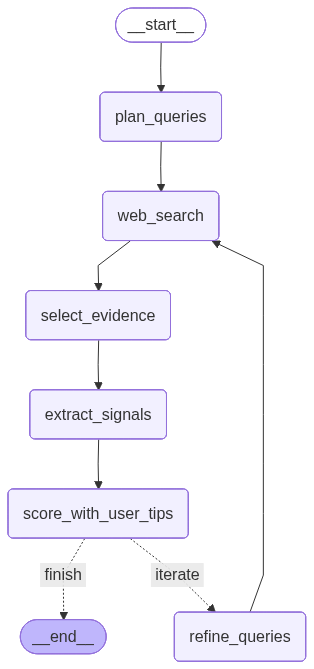

In [9]:
from IPython.display import Image, display
png_bytes = app.get_graph().draw_mermaid_png()
display(Image(png_bytes))